# Confocal ellipsoids

In [1]:
# insert the figures in the notebook
%matplotlib inline

import numpy as np
from numpy.testing import assert_almost_equal as aae
from fatiando import utils, gridder
import triaxial_ellipsoid
from mesher import TriaxialEllipsoid
import plot_functions as pf
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import ellipeinc, ellipkinc

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from plot_functions import savefig

In [2]:
# Set some plot parameters
from matplotlib import rcParams
rcParams['figure.dpi'] = 300.
rcParams['font.size'] = 6
rcParams['xtick.labelsize'] = 'medium'
rcParams['ytick.labelsize'] = 'medium'
rcParams['axes.labelsize'] = 'large'
rcParams['legend.fontsize'] = 'medium'
rcParams['savefig.dpi'] = 300.

### Observation points

In [3]:
# Create a regular grid at 0m height
shape = (200, 200)
area = [-5000, 5000, -5000, 5000]
xp, yp, zp = gridder.regular(area, shape, z = 0)

### Reference ellipsoid

In [4]:
a,b,c = 900., 500., 100.
chi =1.2
ellipsoid = TriaxialEllipsoid(0., 0., 1500., a, b, c, 45., 10., -30.,
                              {'principal susceptibilities': [chi, chi, chi],
                               'susceptibility angles': [0., 0., 0.]})

### Set a local-geomagnetic field parallel to semi-axis $a$

In [5]:
# Intensity of the local-geomagnetic field (in nT)
B0 = 23500.

# Direction parallel to the semi-axis a
_, inc, dec = utils.vec2ang(ellipsoid.transf_matrix.T[0])

In [6]:
print inc, dec

-4.98092532193 15.3783481248


In [7]:
B0x, B0y, B0z = B0*ellipsoid.transf_matrix.T[0]

print B0x, B0y, B0z

22573.0320626 6208.47241509 -2040.36608759


### Magnetic moment of reference

In [8]:
volume = ellipsoid.volume
magnetization = triaxial_ellipsoid.magnetization(ellipsoid, B0, inc, dec, demag=True)
moment = volume*magnetization

print 'magnetization: ', magnetization, ' (A/m)'
print 'volume: ', volume, ' (m^3)'
print 'moment: ', moment, ' (A m^2)'

magnetization:  [ 20.05783327   5.51669374  -1.81301841]  (A/m)
volume:  188495559.215  (m^3)
moment:  [  3.78081250e+09   1.03987227e+09  -3.41745920e+08]  (A m^2)


### Confocal ellipsoid

In [9]:
u = 2.0e6
a_confocal = np.sqrt(a*a + u)
b_confocal = np.sqrt(b*b + u)
c_confocal = np.sqrt(c*c + u)

In [10]:
print a_confocal, b_confocal, c_confocal

1676.30546142 1500.0 1417.74468788


In [11]:
x = ellipsoid.x
y = ellipsoid.y
z = ellipsoid.z

strike = ellipsoid.strike
dip = ellipsoid.dip
rake = ellipsoid.rake

confocal_ellipsoid = TriaxialEllipsoid(x, y, z, a_confocal, b_confocal, c_confocal,
                                       strike, dip, rake,
                                       props={'susceptibility angles': [0., 0., 0.]})

n11, n22, n33 = triaxial_ellipsoid.demag_factors(confocal_ellipsoid)

### Equivalent susceptibility $\chi^{\prime}$

In [12]:
H0 = B0/(4*np.pi*100)
print 'H0:', H0
volume_confocal = confocal_ellipsoid.volume
moment_norm = np.sqrt(np.sum(moment*moment))
chi_confocal = moment_norm/(volume_confocal*H0 - n11*moment_norm)
print 'equivalent chi:', chi_confocal

H0: 18.7007058133
equivalent chi: 0.0141545269247


In [13]:
confocal_ellipsoid.addprop('principal susceptibilities', [chi_confocal, chi_confocal, chi_confocal])

In [20]:
magnetization_confocal = triaxial_ellipsoid.magnetization(confocal_ellipsoid, B0, inc, dec, demag=True)
moment_confocal = volume_confocal*magnetization_confocal

aae(moment, moment_confocal, decimal=5)

### Total-field anomalies computed with the parallel inducing field

In [21]:
# Calculate the total-field anomaly produced by the reference ellipsoid
tf = triaxial_ellipsoid.tf(xp, yp, zp, [ellipsoid], B0, inc, dec)

  
# Calculate the total-field anomaly produced by the confocal ellipsoid
tf_confocal = triaxial_ellipsoid.tf(xp, yp, zp, [confocal_ellipsoid], B0, inc, dec)

In [23]:
# Compare the total-field anomalies
aae(tf, tf_confocal, decimal=12)

### Plot the total-field anomalies produced with the parallel inducing field

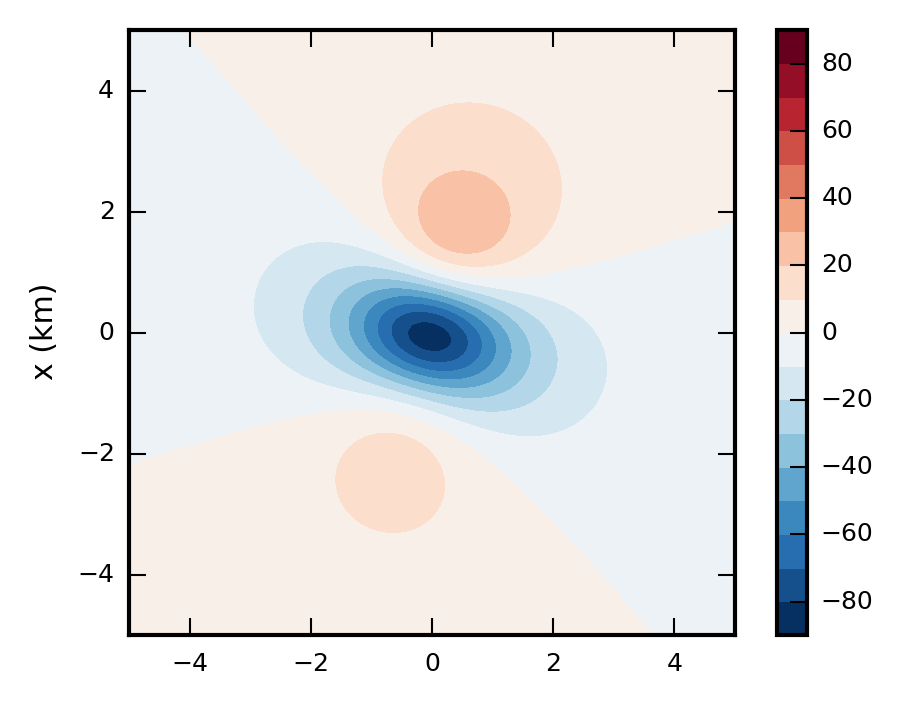

In [24]:
label_loc = (0.88,0.92)

plt.close('all')
plt.figure(figsize=(3.15, 7./3))

plt.axis('scaled')

ranges = np.max(np.abs([np.min(tf), np.max(tf)]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             tf.reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.ylabel('x (km)')
#plt.xlabel('y (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
cbar = plt.colorbar()

plt.tight_layout()
savefig('f03.pdf')

plt.show()

### Total-field anomalies computed with an oblique inducing field

In [25]:
inc_oblique, dec_oblique = -30, 60

In [26]:
# Calculate the total-field anomaly produced by the reference ellipsoid
tf_oblique = triaxial_ellipsoid.tf(xp, yp, zp, [ellipsoid], B0, inc_oblique, dec_oblique)

  
# Calculate the total-field anomaly produced by the confocal ellipsoid
tf_confocal_oblique = triaxial_ellipsoid.tf(xp, yp, zp, [confocal_ellipsoid], B0, inc_oblique, dec_oblique)

In [27]:
# Compare the total-field anomalies
aae(tf_oblique, tf_confocal_oblique, decimal=12)

AssertionError: 
Arrays are not almost equal to 12 decimals

(mismatch 100.0%)
 x: array([ 0.771235205472,  0.775581120891,  0.779740191517, ...,
        1.634756140537,  1.615127343938,  1.595553744003])
 y: array([ 0.554009238031,  0.553872623533,  0.553463507517, ...,
        1.679299243757,  1.659684216571,  1.640098647264])

### Plot the total-field anomalies produced with the oblique inducing field

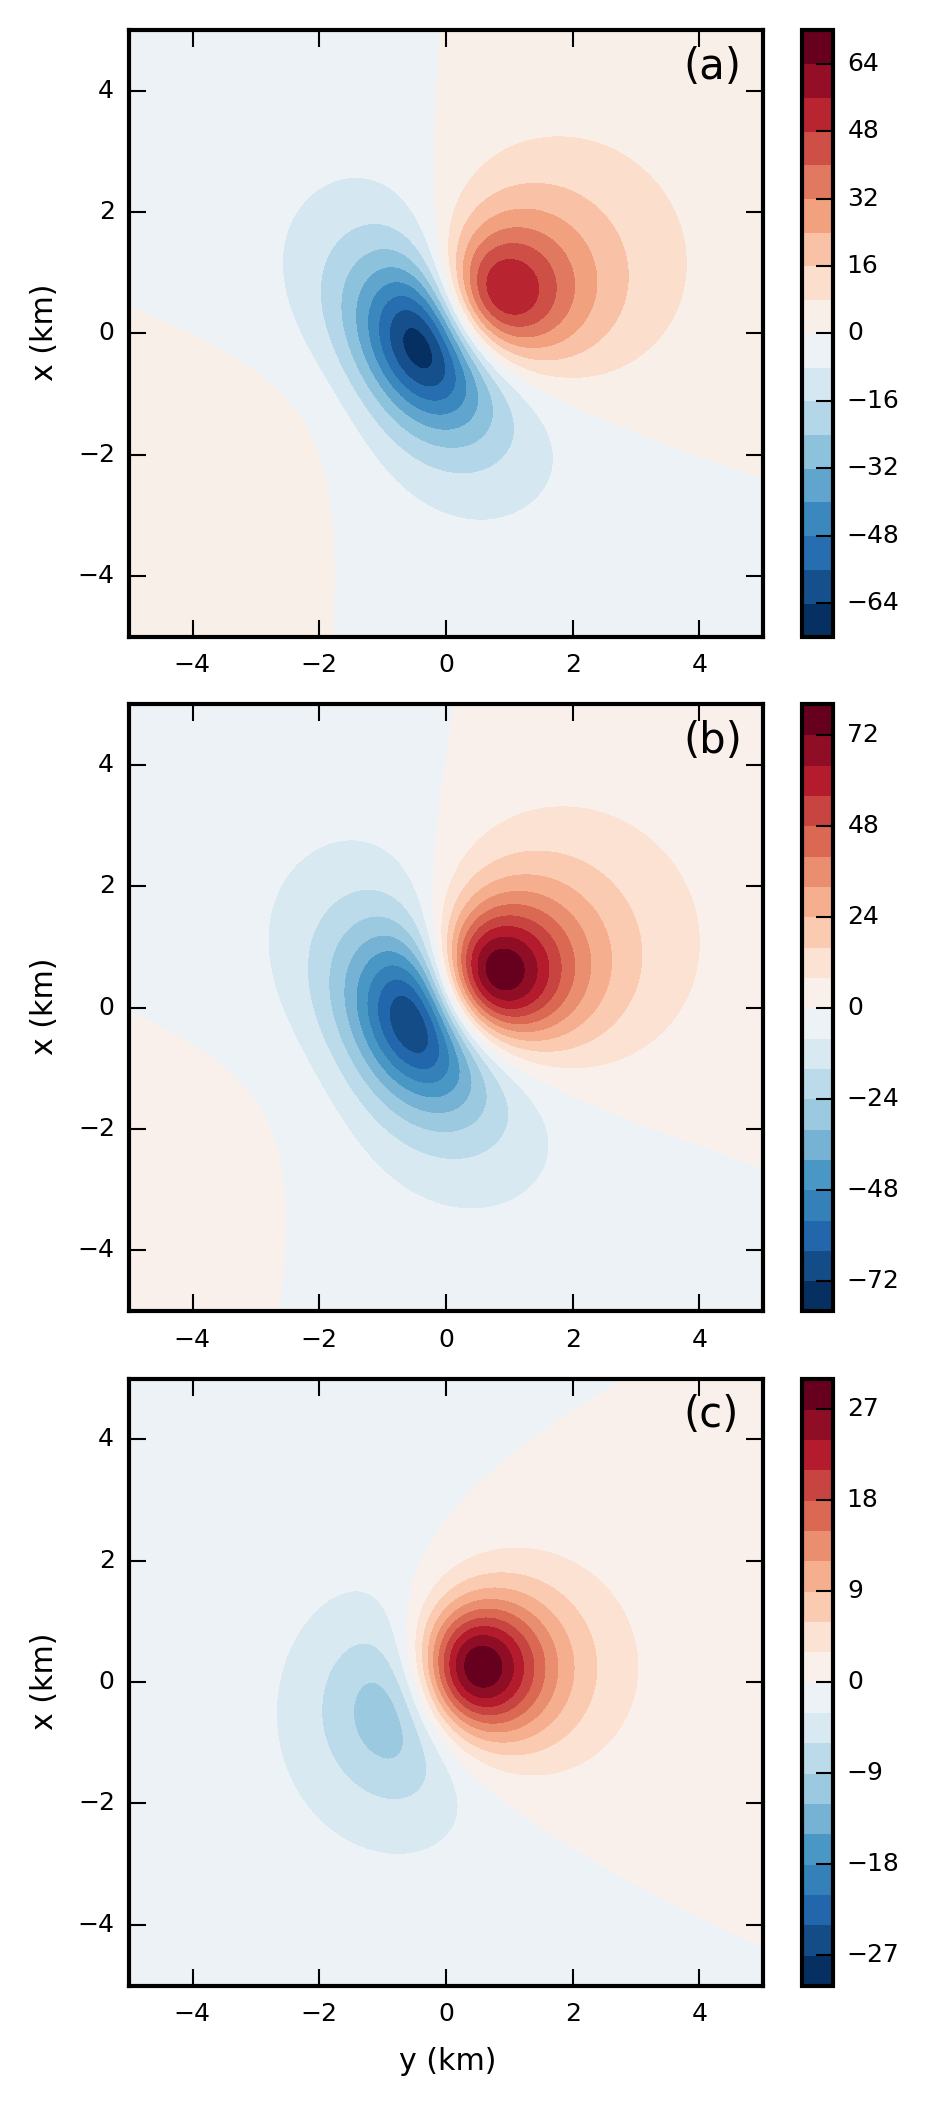

In [28]:
label_loc = (0.88,0.92)

plt.close('all')
plt.figure(figsize=(3.15, 7))

plt.axis('scaled')

ranges = np.max(np.abs([np.min(tf_oblique), np.max(tf_oblique)]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

plt.subplot(3,1,1)
plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             tf_oblique.reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.ylabel('x (km)')
#plt.xlabel('y (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
cbar = plt.colorbar()
plt.annotate(s='(a)', xy=label_loc, 
             xycoords = 'axes fraction', color='k',
             fontsize = 10)


ranges = np.max(np.abs([np.min(tf_confocal_oblique), np.max(tf_confocal_oblique)]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

plt.subplot(3,1,2)
plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             tf_confocal_oblique.reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.ylabel('x (km)')
#plt.xlabel('y (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
cbar = plt.colorbar()
plt.annotate(s='(b)', xy=label_loc, 
             xycoords = 'axes fraction', color='k',
             fontsize = 10)

diff = tf_confocal_oblique - tf_oblique
ranges = np.max(np.abs([np.min(diff), np.max(diff)]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

plt.subplot(3,1,3)
plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             diff.reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.ylabel('x (km)')
plt.xlabel('y (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
cbar = plt.colorbar()
plt.annotate(s='(c)', xy=label_loc, 
             xycoords = 'axes fraction', color='k',
             fontsize = 10)

plt.tight_layout()
savefig('f04.pdf')

plt.show()

### Plot of the confocals ellipsoids

In [29]:
from matplotlib import rcParams
rcParams['contour.negative_linestyle'] = 'solid'

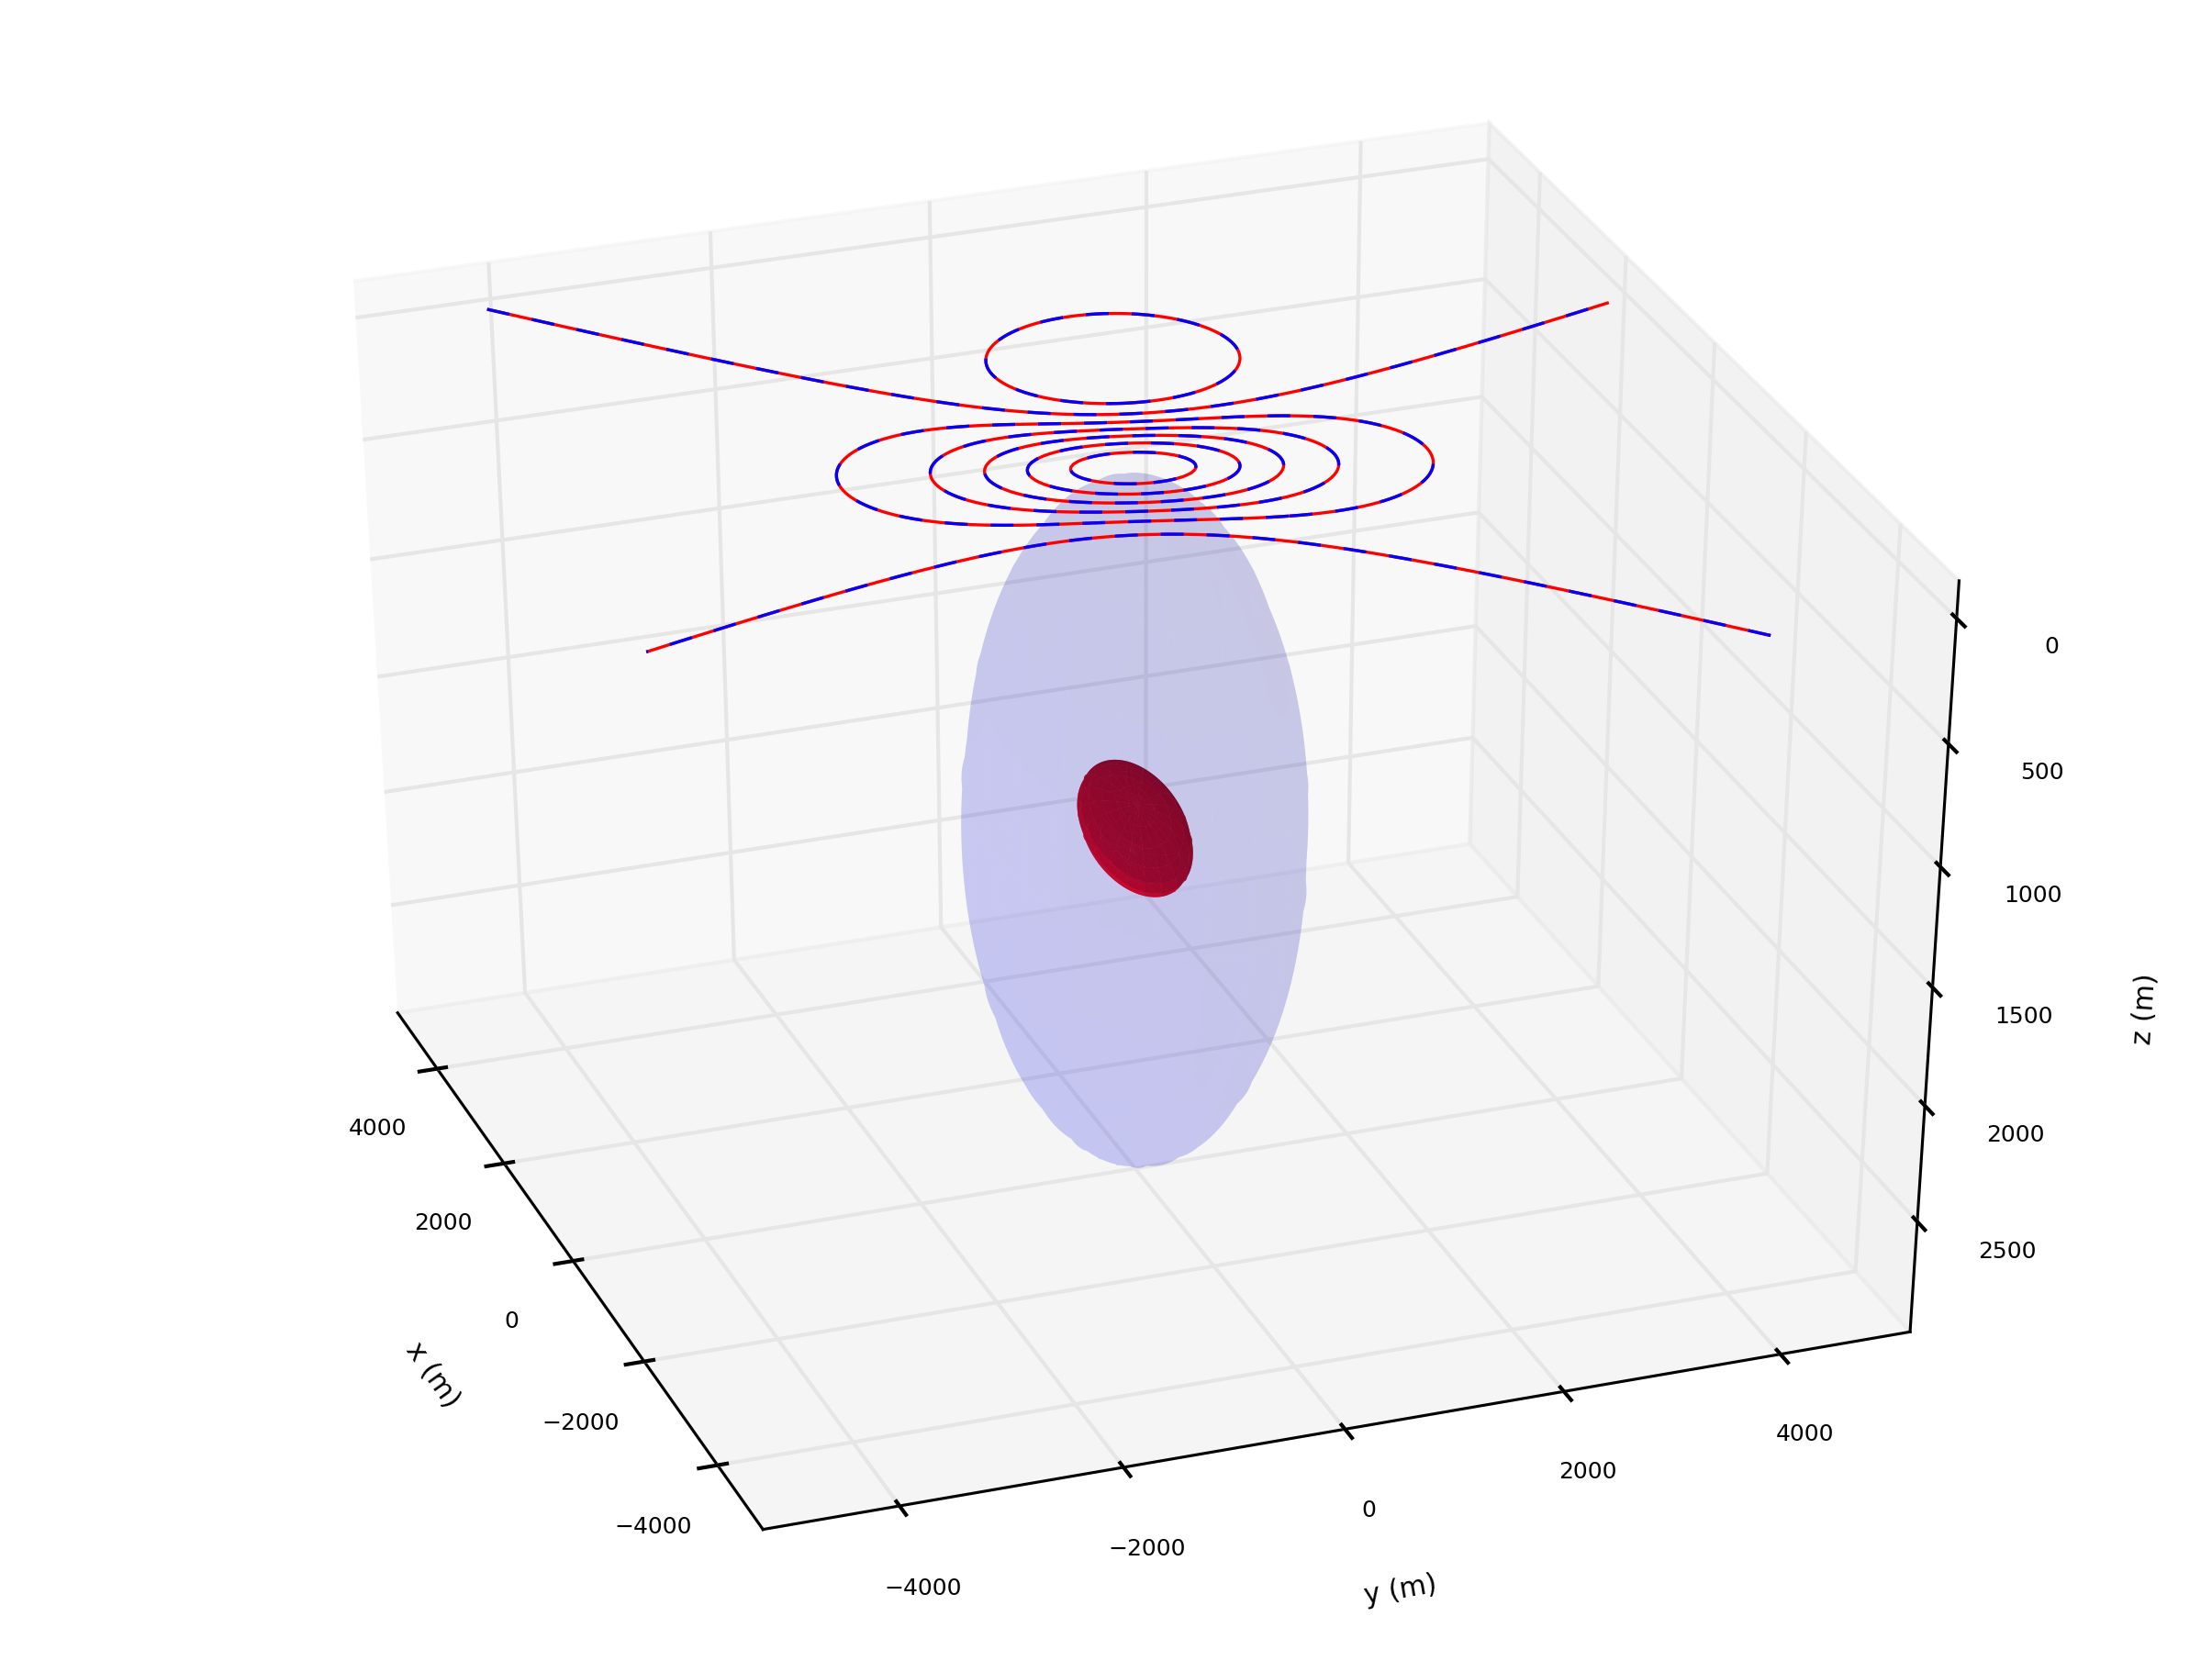

In [30]:
plt.close('all')
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')

ranges = np.max(np.abs([np.min(tf), np.min(tf_confocal),
                        np.max(tf), np.max(tf_confocal)]))
levels = MaxNLocator(nbins=16).tick_values(-ranges, ranges)
cmap = plt.get_cmap('seismic')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=False)

cs = ax.contour(xp.reshape(shape), yp.reshape(shape), tf.reshape(shape),
                zdir='z', offset=0, linestyles='solid', colors='r', levels=levels,
                norm=norm, linewidths=0.8)

cs = ax.contour(xp.reshape(shape), yp.reshape(shape), tf_confocal.reshape(shape),
                zdir='z', offset=-0.1, linestyles='dashed', colors='b', levels=levels,
                norm=norm, linewidths=0.8)

pf.draw_ellipsoid(ax, ellipsoid, body_color=(1,0,0), body_alpha=0.8)

pf.draw_ellipsoid(ax, confocal_ellipsoid, body_color=(0,0,1), body_alpha=0.1)    

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')

ax.view_init(215, 20)

plt.tight_layout(True)

plt.show()

In [31]:
volume_confocal/volume

79.219105439702261

In [32]:
chi/chi_confocal

84.778531022920248